In [1]:
import torch
from transformers import SamProcessor, SamModel
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
from transformers import CLIPProcessor, CLIPModel
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import transformers
import requests
from io import BytesIO

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"torch version: {torch.__version__}, using device: {device}")
print(f"transformers version: {transformers.__version__}")


torch version: 2.6.0+cu124, using device: cuda
transformers version: 4.52.4


In [2]:
url = "https://github.com/sergiovillanueva/prompt_to_mask/raw/master/assets/image.jpg"
image = Image.open(BytesIO(requests.get(url).content)).convert("RGB")

In [10]:
# models
dino_processor = AutoProcessor.from_pretrained("IDEA-Research/grounding-dino-base")
dino_model = AutoModelForZeroShotObjectDetection.from_pretrained("IDEA-Research/grounding-dino-base").to(device)

sam_processor = SamProcessor.from_pretrained("facebook/sam-vit-large")
sam_model = SamModel.from_pretrained("facebook/sam-vit-large").to(device)

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base", torch_dtype=torch.float16).to("cuda")

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [ ]:
# dino
# Ajustar tamaño para DINO
w, h = image.size
scale = min(768 / max(h, w), 1.0)
new_h, new_w = int(h * scale), int(w * scale)


prompt = ["grey cars", "person"]

# Aplicar Grounding DINO - procesamiento directo
inputs = dino_processor(
    images=image,
    text=prompt,
    return_tensors="pt",
    do_resize=True,
    size={"height": new_h, "width": new_w}
).to(device)

# Ejecutar DINO para detección
with torch.no_grad():
    outputs = dino_model(**inputs)

results = dino_processor.post_process_grounded_object_detection(
            outputs,
            inputs.input_ids,
            threshold=0.5,
            text_threshold=0.5,
            target_sizes=[(h, w)])

boxes = results[0]['boxes']
labels = results[0]['labels']
scores = results[0]['scores']

# Mostrar resultados
for box, label, score in zip(boxes, labels, scores):
    print(f"Box: {box}, Label: {label}, Score: {score}")


img_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
for box, label, score in zip(boxes, labels, scores):
    x0, y0, x1, y1 = map(int, box)
    cv2.rectangle(img_cv, (x0, y0), (x1, y1), (0,0,255), 2)
    txt = f"{label} {score:.2f}"
    cv2.putText(img_cv, txt, (x0, y0-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,255), 2)
plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


In [ ]:
# sam
box = [748, 274, 1021, 405]

inputs = sam_processor(images=image, input_boxes=[[box]], return_tensors="pt").to(device)

with torch.no_grad():
    outputs = sam_model(**inputs)

masks = sam_processor.post_process_masks(
    outputs.pred_masks, inputs["original_sizes"], inputs["reshaped_input_sizes"]
)

best_mask = masks[0][0][outputs.iou_scores.argmax()].cpu().numpy()

print(f"Mask shape: {best_mask.shape}")


plt.imshow(best_mask, cmap="gray")
plt.axis("off")
plt.show()



In [ ]:
# dino + sam
w, h = image.size
scale = min(768 / max(h, w), 1.0)
new_h, new_w = int(h * scale), int(w * scale)

prompt = ["car", "person"]

inputs = dino_processor(
    images=image,
    text=prompt,
    return_tensors="pt",
    do_resize=True,
    size={"height": new_h, "width": new_w}
).to(device)

with torch.no_grad():
    outputs = dino_model(**inputs)

results = dino_processor.post_process_grounded_object_detection(
            outputs,
            inputs.input_ids,
            threshold=0.5,
            text_threshold=0.5,
            target_sizes=[(h, w)])

boxes = results[0]['boxes'].cpu().numpy().tolist()
scores = results[0]['scores'].cpu().numpy().tolist()
labels = results[0]['labels']


final_mask = np.zeros((h, w), dtype=np.float32)


for i, (box, label, score) in enumerate(zip(boxes, labels, scores)):
    print(f"Processing {label} (score: {score:.3f})")
    sam_inputs = sam_processor(images=image, input_boxes=[[box]], return_tensors="pt").to(device)

    with torch.no_grad():
        sam_outputs = sam_model(**sam_inputs)

    masks = sam_processor.post_process_masks(
        sam_outputs.pred_masks, sam_inputs["original_sizes"], sam_inputs["reshaped_input_sizes"]
    )

    best_mask = masks[0][0][sam_outputs.iou_scores.argmax()].cpu().numpy()

    final_mask += best_mask

final_mask = np.clip(final_mask, 0, 1)

print(f"Final mask shape: {final_mask.shape}")

plt.imshow(final_mask, cmap="gray")
plt.axis("off")
plt.show()




In [ ]:
# dino + sam batch
w, h = image.size
scale = min(768 / max(h, w), 1.0)
new_h, new_w = int(h * scale), int(w * scale)

prompt = ["car", "person"]

inputs = dino_processor(
    images=image,
    text=prompt,
    return_tensors="pt",
    do_resize=True,
    size={"height": new_h, "width": new_w}
).to(device)

with torch.no_grad():
    outputs = dino_model(**inputs)

results = dino_processor.post_process_grounded_object_detection(
            outputs,
            inputs.input_ids,
            threshold=0.5,
            text_threshold=0.5,
            target_sizes=[(h, w)])

boxes = results[0]['boxes'].cpu().numpy().tolist()
scores = results[0]['scores'].cpu().numpy().tolist()
labels = results[0]['labels']


if len(boxes) > 0:
    sam_inputs = sam_processor(images=image, input_boxes=[boxes], return_tensors="pt").to(device)

    with torch.no_grad():
        sam_outputs = sam_model(**sam_inputs)

    masks = sam_processor.post_process_masks(
        sam_outputs.pred_masks, sam_inputs["original_sizes"], sam_inputs["reshaped_input_sizes"]
    )

    iou_scores = sam_outputs.iou_scores.cpu().numpy()
    final_mask = np.zeros((h, w), dtype=np.float32)

    for i in range(len(boxes)):
        detection_masks = masks[0][i].cpu().numpy()
        best_idx = iou_scores[0][i].argmax()
        final_mask += detection_masks[best_idx]

    final_mask = np.clip(final_mask, 0, 1)
    print(f"Processed {len(boxes)} detections in single batch")
else:
    final_mask = np.zeros((h, w), dtype=np.float32)

plt.imshow(final_mask, cmap="gray")
plt.axis("off")
plt.show()


In [ ]:
# clip
descriptions = ["a photo of a street with a person", "a photo of a dog", "a photo of several cars but without any person on it"]

inputs = clip_processor(text=descriptions, images=image, return_tensors="pt", padding=True)

outputs = clip_model(**inputs)
logits_per_image = outputs.logits_per_image
probs = logits_per_image.softmax(dim=1)

for desc, prob in zip(descriptions, probs[0].tolist()):
    print(f"'{desc}' -> Probability: {prob:.2f}")


'a photo of a street with a person' -> Probability: 0.91
'a photo of a dog' -> Probability: 0.00
'a photo of several cars but without any person on it' -> Probability: 0.09


In [ ]:
# blip
inputs = blip_processor(image, return_tensors="pt").to("cuda", torch.float16)
out = blip_model.generate(**inputs)
print(blip_processor.decode(out[0], skip_special_tokens=True))

a photography of a woman crossing a street


In [7]:
import torch
import requests
from PIL import Image
from io import BytesIO
from transformers import Blip2Processor, Blip2ForConditionalGeneration
from matplotlib import pyplot as plt
import cv2
from transformers import BitsAndBytesConfig

quant_config = BitsAndBytesConfig(load_in_8bit=True)

blip2_processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
blip2_model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-2.7b",
    quantization_config=quant_config,
    device_map="auto"
)

url = "https://github.com/sergiovillanueva/prompt_to_mask/raw/master/assets/image.jpg"
image = Image.open(BytesIO(requests.get(url).content)).convert("RGB")


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

how many cars are in the picture?


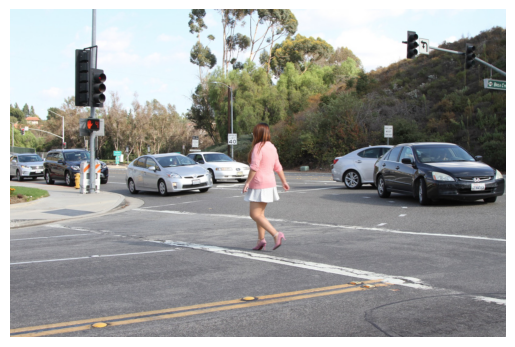

In [11]:
question = "how many cars are in the picture?"
inputs = blip2_processor(image, question, return_tensors="pt").to("cuda", torch.float16)

out = blip2_model.generate(**inputs)
print(blip2_processor.decode(out[0], skip_special_tokens=True).strip())

plt.imshow(image)
plt.axis("off")
plt.show()